In [3]:
pip install lifelines


[notice] A new release of pip available: 22.3 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import pandas as pd
import numpy as np
import os
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter
import warnings
warnings.filterwarnings("ignore")
from statsmodels.stats.multitest import multipletests
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter

In [5]:
full_data = pd.read_csv('Full Data.txt', index_col = [0])

In [6]:
full_data

,gender,ajcc_pathologic_tumor_stage,tumor_status,DSS,DSS.time,TP53,TTN,FAT1,MUC16,CSMD3,...,NIPBL,CEACAM5,CEACAM6,CLCA4,EGFR,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,age
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,1,0,0,0.0,0.279452,822.678,1157.3300,1620.71,1004.4700,1.2325,...,1595.440,56.0776,423.3550,502.2340,722.847,92,8,0,2,1
TCGA-BA-4074,1,0,1,1.0,1.265753,1805.510,103.6870,6415.45,17.3422,0.3854,...,1605.890,153.3820,275.9330,12.7176,1267.900,106,8,0,1,1
TCGA-BA-4075,1,1,1,1.0,0.775342,383.760,295.9180,4162.40,1.0720,36.9824,...,907.410,18.2232,45.5581,10.1836,4833.430,113,10,0,4,0
TCGA-BA-4077,0,0,1,1.0,3.106849,1929.260,207.3870,7246.87,432.6270,0.0000,...,1174.690,2392.6900,2437.9200,720.8850,2371.940,234,20,0,6,0
TCGA-BA-5149,1,0,1,1.0,2.208219,165.298,347.9540,8848.73,110.5410,0.3422,...,1798.770,37.3032,447.6390,5.4757,6934.280,96,6,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JO,0,0,1,1.0,1.728767,1604.880,176.1930,1881.36,347.7040,2.8008,...,854.256,1498.8500,2014.6000,82.8248,530.911,135,9,0,4,1
TCGA-UF-A7JS,1,0,1,1.0,1.863014,2457.400,1379.4300,1339.31,243.6470,19.4320,...,982.063,358.7440,294.4690,32.8849,246.637,50,1,0,1,1
TCGA-UF-A7JT,0,0,1,1.0,2.720548,1684.850,149.5190,3430.74,213.8530,14.2857,...,1009.520,49.7835,209.5240,200.4330,790.905,152,10,0,3,1


In [54]:
full_data.isna()

,gender,ajcc_pathologic_tumor_stage,tumor_status,DSS,DSS.time,TP53,TTN,FAT1,MUC16,CSMD3,...,EGFR,Missense_Mutation,Nonsense_Mutation,Nonstop_Mutation,Splice_Site,age,Missense_Mutationbinary,Nonsense_Mutationbinary,Nonstop_Mutationbinary,Splice_Sitebinary
patient_id,,,,,,,,,,,,,,,,,,,,,
TCGA-4P-AA8J,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True
TCGA-BA-4074,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
TCGA-BA-4075,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
TCGA-BA-4077,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TCGA-BA-5149,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-UF-A7JO,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,False
TCGA-UF-A7JS,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
TCGA-UF-A7JT,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,True,False,True


In [64]:
test_data=full_data
test_data=test_data.dropna(axis=0, how='any')

# Simple Columns

# Log-rank test

Log-rank on mutations using 3 features.

In [42]:
def quantile_gene(df, x):
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    df[x + 'binary'] = df[x].apply(lambda x: 0 if x <= q1 else 1 if x >= q3 else np.nan)

In [43]:
def ten_mutations(x):
    q1 = merged_mutation[x].quantile(0.25)
    q3 = merged_mutation[x].quantile(0.75)
    merged_mutation[ x + 'binary'] = mutation_counts[x].apply(lambda x: 0 if x <= q1 else 1 if x >= q3 else np.nan)

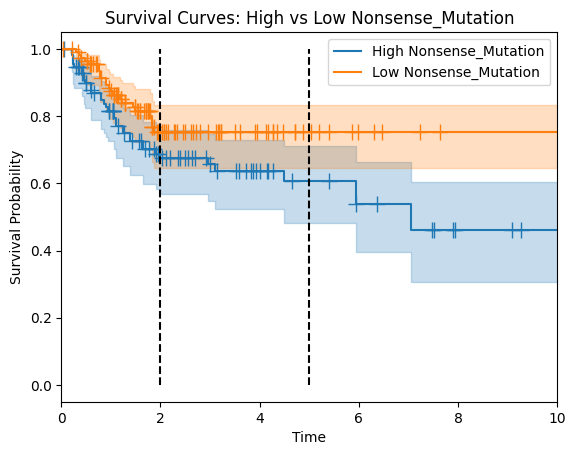

Significant gene for survival analysis Nonsense_Mutation. Test statistic: 3.782347185684057. p-value: 0.051795954219451254


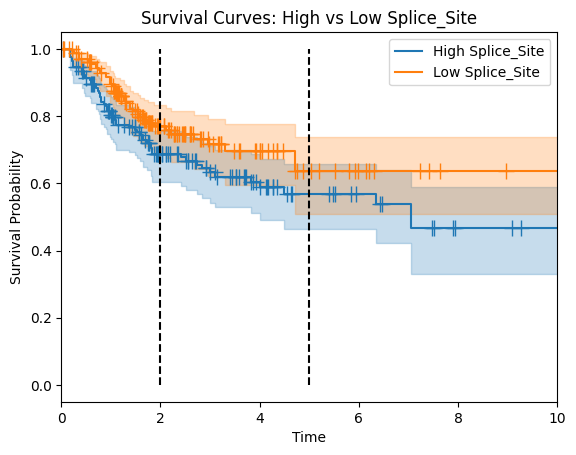

Significant gene for survival analysis Splice_Site. Test statistic: 3.4874298886925175. p-value: 0.06183651710427038


In [53]:

for i in mutation:
        quantile_gene(full_data,i)
        low_expression = full_data[full_data[i + 'binary'] == 0]
        high_expression =  full_data[full_data[i + 'binary'] == 1]
        # logrank
        results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                    high_expression['DSS'], low_expression['DSS'])
        z_value = results.test_statistic
        if z_value > 1.96 or z_value < -1.96:
            kmf = KaplanMeierFitter()

            # Fit the survival curves for high and low expression groups
            kmf.fit(high_expression['DSS.time'], event_observed=high_expression['DSS'], label='High ' + i )
            kmf.plot(show_censors=True)

            kmf.fit(low_expression['DSS.time'], event_observed=low_expression['DSS'], label='Low ' + i )
            kmf.plot(show_censors=True)
            plt.vlines(2,0,1, color='k', linestyles='dashed')
            plt.vlines(5,0,1, color='k', linestyles='dashed')
            # Add labels and legend
            plt.xlim(0,10)
            plt.xlabel('Time')
            plt.ylabel('Survival Probability')
            plt.title('Survival Curves: High vs Low ' + i )
            plt.legend()

            # Show the plot
            plt.show()
            print("Significant gene for survival analysis " + i + ". Test statistic: " + str(z_value)+ ". p-value: " + str(results.p_value))

In [19]:
def logrank(df, lis, time):
    dic ={}
    data = df[df['DSS.time'] <= time]
    for i in lis:
        quantile_gene(full_data, i)
        low_expression = full_data[full_data[i + 'binary'] == 0]
        high_expression =  full_data[full_data[i +'binary'] == 1]
        # logrank
        results = logrank_test(high_expression['DSS.time'], low_expression['DSS.time'],
                       high_expression['DSS'], low_expression['DSS'])
        z_value = results.test_statistic
        if z_value > 1.96 or z_value < -1.96:
            dic[i] = z_value
    
    # return a dictionary of name and z value
    return dic

In [20]:
gene_expression = list(full_data.drop(columns = ['gender', 'ajcc_pathologic_tumor_stage', 'tumor_status', 'DSS' ,
                                      'DSS.time', 'Missense_Mutation', 'Nonsense_Mutation', 
                                      'Nonstop_Mutation', 'Splice_Site', 'age']).columns)

In [21]:
# for gene expression
a = logrank(full_data,gene_expression, 2) # example: use full data and 2 years as limit

In [22]:
time_limit = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] #run this first and then run the classification, but 
feature_dic = {}
for i in time_limit:
    dic = logrank(full_data, gene_expression, i)
    feature_dic[i] = list(dic.keys())

In [60]:
print(feature_dic)

{1: ['TTN', 'NSD1', 'DMD', 'SI', 'XIRP2', 'MUC17', 'AHNAK2', 'DNAH9', 'CDH10', 'PEG3', 'DCHS2', 'LRRC4C'], 2: ['TTN', 'MUC16', 'NOTCH1', 'FLG', 'COL11A1', 'PKHD1L1', 'AHNAK', 'XIRP2', 'MUC17', 'PCDH15', 'AHNAK2', 'DNAH8', 'NEB', 'RP1', 'DNAH7', 'CDH10', 'DCHS2', 'EGFR', 'Nonsense_Mutationbinary', 'Splice_Sitebinary'], 3: ['TTN', 'MUC16', 'CDKN2A', 'NOTCH1', 'PKHD1L1', 'AHNAK', 'XIRP2', 'CUBN', 'MUC17', 'PCDH15', 'AHNAK2', 'FAT4', 'ABCA13', 'NEB', 'UNC13C', 'DNAH7', 'VPS13B', 'DCHS2', 'RYR1', 'CEACAM5', 'Nonsense_Mutationbinary', 'Splice_Sitebinary'], 4: ['TTN', 'MUC16', 'CDKN2A', 'NOTCH1', 'AHNAK', 'SI', 'XIRP2', 'CUBN', 'PCDH15', 'FAT4', 'MACF1', 'DNAH8', 'ABCA13', 'CSMD1', 'NEB', 'RP1', 'UNC13C', 'DNAH7', 'CDH10', 'VPS13B', 'DCHS2', 'CREBBP', 'LRP1', 'RYR1', 'CLCA4', 'Nonsense_Mutationbinary', 'Splice_Sitebinary'], 5: ['TTN', 'MUC16', 'NOTCH1', 'AHNAK', 'XIRP2', 'CUBN', 'MUC17', 'AHNAK2', 'FAT4', 'DNAH8', 'ABCA13', 'HERC2', 'CSMD1', 'NEB', 'UNC13C', 'DNAH7', 'CDH10', 'VPS13B', 'CREBB

In [23]:
#select top n genes by sort z values as features from full_data

In [24]:
mutation = ['Missense_Mutation', 'Nonsense_Mutation', 'Nonstop_Mutation', 'Splice_Site']

In [25]:
# for mutation
logrank(full_data,mutation, 2) # example: use full data and 2 years as limit

{'Missense_Mutation': 2.829742067441412,
 'Nonsense_Mutation': 7.6225327611969105,
 'Splice_Site': 5.872128938552734}

# Classification

In [26]:
#select top n mutations by z values as features columns from full_data

df = full_data
features are from the data

In [65]:
def classification_svm(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # SVM
   
    # Define the model
    svm_clf = svm.SVC()

    # Train the model
    svm_clf.fit(X_train, y_train)
   
    # Predict on the test set
    svm_predictions = svm_clf.predict(X_test)

    # Evaluate the model
    return accuracy_score(y_test, svm_predictions)
    #print("SVM Accuracy:", accuracy_score(y_test, svm_predictions))

In [68]:
#acc svm for gene expression
acc_svm = []
for i in time_limit:
    lis = []
    for k in range(100):
        accuracy = classification_svm(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    acc_svm.append(mean_acc)
    print('For time limit' + str(i) + ' and gene expression features from Log rank test: ')
    print('SVM Accuracy' + str(mean_acc))

For time limit1 and gene expression features from Log rank test: 
SVM Accuracy0.7619354838709675
For time limit2 and gene expression features from Log rank test: 
SVM Accuracy0.7735483870967741
For time limit3 and gene expression features from Log rank test: 
SVM Accuracy0.7612903225806452
For time limit4 and gene expression features from Log rank test: 
SVM Accuracy0.7761290322580643
For time limit5 and gene expression features from Log rank test: 
SVM Accuracy0.767096774193548
For time limit6 and gene expression features from Log rank test: 
SVM Accuracy0.7703225806451617
For time limit7 and gene expression features from Log rank test: 
SVM Accuracy0.7548387096774194
For time limit8 and gene expression features from Log rank test: 
SVM Accuracy0.7551612903225808
For time limit9 and gene expression features from Log rank test: 
SVM Accuracy0.7677419354838707
For time limit10 and gene expression features from Log rank test: 
SVM Accuracy0.763548387096774


In [69]:
for i in time_limit:
    lis = []
    for k in range(10000):
        accuracy = classification_svm(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test')
    print('SVM Accuracy ' + str(mean_acc))

For time limit 1 and gene expression features from Log rank test
SVM Accuracy 0.7609129032259039
For time limit 2 and gene expression features from Log rank test
SVM Accuracy 0.7608032258065489
For time limit 3 and gene expression features from Log rank test
SVM Accuracy 0.7618806451613893
For time limit 4 and gene expression features from Log rank test
SVM Accuracy 0.7605580645162293
For time limit 5 and gene expression features from Log rank test
SVM Accuracy 0.760806451613003
For time limit 6 and gene expression features from Log rank test
SVM Accuracy 0.7604064516130037
For time limit 7 and gene expression features from Log rank test
SVM Accuracy 0.7623419354839689
For time limit 8 and gene expression features from Log rank test
SVM Accuracy 0.7617032258065497
For time limit 9 and gene expression features from Log rank test
SVM Accuracy 0.7614032258065476
For time limit 10 and gene expression features from Log rank test
SVM Accuracy 0.7607032258065509


In [70]:
def classifcation_randomforest(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()

    # Train the model
    rf_clf.fit(X_train, y_train)
    # Predict on the test set
    rf_predictions = rf_clf.predict(X_test)

    # Evaluate the model
    return accuracy_score(y_test, rf_predictions)
    #print("Random Forest Accuracy:", accuracy_score(y_test, rf_predictions))

In [71]:
for i in time_limit:
    lis = []
    for k in range(100): #change to 100 
        accuracy = classifcation_randomforest(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test: ') #change to logrank
    print('Random Forest Accuracy ' + str(mean_acc))

For time limit 1 and gene expression features from Log rank test: 
Random Forest Accuracy 0.741612903225806
For time limit 2 and gene expression features from Log rank test: 
Random Forest Accuracy 0.73516129032258
For time limit 3 and gene expression features from Log rank test: 
Random Forest Accuracy 0.7390322580645156
For time limit 4 and gene expression features from Log rank test: 
Random Forest Accuracy 0.7425806451612905
For time limit 5 and gene expression features from Log rank test: 
Random Forest Accuracy 0.736774193548387
For time limit 6 and gene expression features from Log rank test: 
Random Forest Accuracy 0.74516129032258
For time limit 7 and gene expression features from Log rank test: 
Random Forest Accuracy 0.7551612903225806
For time limit 8 and gene expression features from Log rank test: 
Random Forest Accuracy 0.7309677419354838
For time limit 9 and gene expression features from Log rank test: 
Random Forest Accuracy 0.7422580645161286
For time limit 10 and gen

In [72]:
def best_estimator(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_clf = RandomForestClassifier()
    param_grid = { 
    'n_estimators': [10, 50, 100, 200],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']}
    # Train the model
    CV_rf = GridSearchCV(estimator=rf_clf, param_grid=param_grid, cv = 5)
    CV_rf.fit(X_train, y_train)
    # Predict on the test set
    return CV_rf.best_params_

In [73]:
# get the best parameter for each time based on each feature
para_dic = {}
for i in time_limit:
    para_dic[i] = best_estimator(test_data, feature_dic[i])

In [74]:
def classifcation_randomforestcv(df, features, best_para):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    rf_best = RandomForestClassifier(n_estimators= best_para['n_estimators'], max_features=best_para['max_features'], max_depth=best_para['max_depth'], criterion=best_para['criterion'])
    rf_best.fit(X_train, y_train)

    predictions = rf_best.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    cv_score = cross_val_score(rf_best, X, y, cv=5)
    # Evaluate the model
    return accuracy, cv_score.mean()

In [75]:
for i in time_limit:
    lis_grid = []
    lis_cv = []
    for k in range(10):
        grid_accuracy, cv_score = classifcation_randomforestcv(test_data, feature_dic[i],para_dic[i])
        lis_grid.append(grid_accuracy)
        lis_cv.append(cv_score)
    mean_grid = sum(lis_grid)/len(lis_grid)
    mean_cv =  sum(lis_cv)/len(lis_cv)
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test: ')
    print('Random Forest GridSearchCV Accuracy ' + str(mean_grid))
    print('Random Forest cross validation Accuracy ' + str(mean_cv))

For time limit 1 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7290322580645163
Random Forest cross validation Accuracy 0.7308602150537634
For time limit 2 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7193548387096775
Random Forest cross validation Accuracy 0.7332688172043011
For time limit 3 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.7064516129032259
Random Forest cross validation Accuracy 0.7219139784946236
For time limit 4 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.6967741935483872
Random Forest cross validation Accuracy 0.7238709677419355
For time limit 5 and gene expression features from Log rank test: 
Random Forest GridSearchCV Accuracy 0.738709677419355
Random Forest cross validation Accuracy 0.7543870967741937
For time limit 6 and gene expression features from Log rank test: 
Random Forest GridSearchCV Ac

In [76]:
def classification_logistic(df, features):
    # get features you select
    X = df[features]
    y = df['DSS']

    # Split the dataset into training and testing datasets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
    # add classification
    # choose any classfication to do prediction
    # Define the model
    log_reg = LogisticRegression()

    # Train the model
    log_reg.fit(X_train, y_train)
    log_reg_predictions = log_reg.predict(X_test)

    # Evaluate the model
    return accuracy_score(y_test, log_reg_predictions)
    #print("Logistic Regression Accuracy:", accuracy_score(y_test, log_reg_predictions))

In [77]:
for i in time_limit:
    lis = []
    for k in range(10000):
        accuracy = classification_logistic(test_data, feature_dic[i])
        lis.append(accuracy)
    mean_acc = sum(lis)/len(lis)
    print('For time limit ' + str(i) + ' and gene expression features from Log rank test')
    print('Logistic Regression Accuracy ' + str(mean_acc))

For time limit 1 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7443032258065462
For time limit 2 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7312709677420303
For time limit 3 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7280096774194477
For time limit 4 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7116516129033149
For time limit 5 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7109290322581533
For time limit 6 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7306709677420288
For time limit 7 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7351935483871906
For time limit 8 and gene expression features from Log rank test
Logistic Regression Accuracy 0.7253483870968682
For time limit 9 and gene expression features from Log rank test
Logistic Regression Accuracy 0.